# Text Clustering


Dataset: https://www.kaggle.com/dodyagung/accident


## Load dependencies

In [23]:
import pandas as pd
import numpy as np

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

#import fasttext

from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import pickle

## Load and preprocess dataset
You may download the data from Kaggle first then upload it here.

In [6]:
data = pd.read_csv('twitter_label_manual.csv')

In [7]:
def text_preprocess(series, stemmer, stopwords):
    df = series.str.replace("\n\t",  " ")
    df = df.str.replace(r"[^a-zA-Z ]+", "")
    df = df.str.lower()
    df = df.apply(lambda x: ' '.join([stemmer.stem(item) for item in x.split() if item not in stopwords]))
    
    return df

In [8]:
stopwords = StopWordRemoverFactory().get_stop_words()
stemmer = StemmerFactory().create_stemmer()

In [9]:
data['processed_text'] = text_preprocess(data['full_text'], stemmer, stopwords)

C:\Users\Rajmohan\AppData\Local\Temp/ipykernel_22952/790257583.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df = df.str.replace(r"[^a-zA-Z ]+", "")


# Using pretrained glove vector

In [25]:
with open('glove_vectors','rb') as f:
    model = pickle.load(f)
    glove_words = set(model.keys())

In [28]:
word_embedding =[]
for sentence in data['processed_text']:
    vector = np.zeros(300)
    for word in sentence.split():
        if word in glove_words:
            vector += model[word]
    word_embedding.append(vector)

## Clustering Attempt
Use Elbow Method to find the optimal number of k.
Here, we'll use K-means algorithm for clustering. You may experiment with other algorithms.

### Elbow Method

In [34]:
sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(pd.DataFrame(word_embedding))
    sum_of_squared_distances.append(km.inertia_)

C:\Users\Rajmohan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


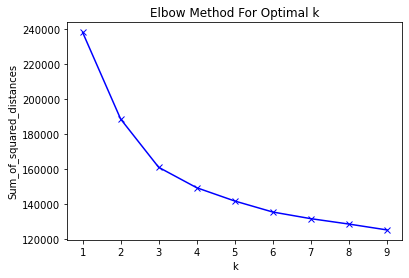

In [36]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### KMeans Clustering

In [37]:
kmeans = KMeans(n_clusters=3)  
kmeans.fit(word_embedding)

KMeans(n_clusters=3)

In [38]:
data['cluster'] = kmeans.fit_predict(word_embedding)

In [39]:
data.groupby(['cluster'])['is_accident'].value_counts()

cluster  is_accident
0        0              131
         1               62
1        0              505
         1              298
2        0                6
Name: is_accident, dtype: int64

### Dimension Reduction
If you want to visualize it, we can't really visualize 100 dimensions. So we use dimension reduction technique to try and visualize it.

In [40]:
pca = PCA(n_components=3)
data['x'] = pca.fit_transform(word_embedding)[:,0]
data['y'] = pca.fit_transform(word_embedding)[:,1]
data['z'] = pca.fit_transform(word_embedding)[:,2]

In [41]:
print(pca.explained_variance_ratio_)

[0.39984057 0.0735406  0.06046677]


#### 2D Scatterplot

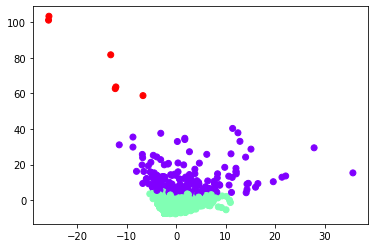

In [43]:
plt.scatter(data['y'],data['x'], c=data['cluster'], cmap='rainbow')

#### 3D Scatterplot

C:\Users\Rajmohan\AppData\Local\Temp/ipykernel_22952/4001652280.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)


Text(0.5, 0.92, 'Tweet Clustering using K Means')

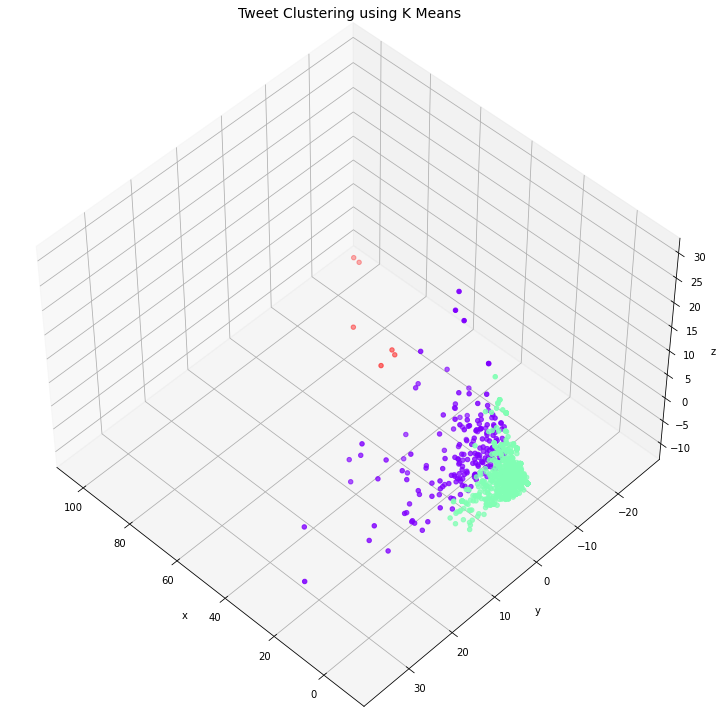

In [44]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(10,10))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(data['x'],data['y'],data['z'], c=data['cluster'], cmap='rainbow')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_facecolor('white')
plt.title("Tweet Clustering using K Means", fontsize=14)